In [1]:
import torch
import pandas as pd
import numpy as np

import sys
sys.path.append('../')


from dataloader.dataloader import *
from training.training import *
from models.rae import *
from utils.utils import *
from visualizations.visualizations import *
from evaluation.evaluation import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

CUDA is available. Training on GPU.


In [3]:
data_folder = "../Data/Data v5"

In [4]:
df = pd.read_csv(os.path.join(data_folder, "amari_ue_data_final_v5_no_outliers_scaled.csv"))
df = df.sort_values(["imeisv", "_time"], ascending = True)

benign_data_starting_point = "2024-03-20 14:14:50.19"
benign_data_ending_point = "2024-03-23 16:26:19.00"


filter_1 = (df['_time'].between(benign_data_starting_point, benign_data_ending_point))
filter_2 = (~df['imeisv'].isin(['8642840401594200', '8642840401612300','8642840401624200','3557821101183501']))

df.drop(df[filter_1 & filter_2].index, inplace = True)

In [5]:
benign_data = df[df['label'] == 0].copy()
benign_data = benign_data.sort_values(['imeisv','_time'])
print(benign_data.shape[0])
malicious_data = df[df['label'] == 1].copy()
malicious_data = malicious_data.sort_values(['imeisv','_time'])
print(malicious_data.shape[0])

263283
15037


In [6]:
f = open("../results/experiments_metadata.json")
exp_metadata = json.load(f)

In [7]:
data_for_df = {}
for exp_id, exp_info in exp_metadata.items():
    parameters = exp_info['parameters']
    flattened_info = {
        **parameters,
        'epochs_trained':exp_info['epochs_trained'], 
        'results_file': exp_info['results_file'], 
        'timestamp': exp_info['timestamp'],
        'min_train_loss': exp_info['min_train_loss'],
        'min_val_loss': exp_info['min_val_loss'],
        'min_train_val_gap': exp_info['min_train_val_gap'],
        'features': exp_info['feature_columns'],
        'rolling_avg': exp_info['rolling_avg'],
        'dataset_used': exp_info['dataset_used']
        }
    data_for_df[exp_id] = flattened_info

exp_df = pd.DataFrame.from_dict(data_for_df, orient='index')

In [9]:
exp_df.shape

(192, 19)

In [23]:
exp_df.sort_values('min_train_val_gap', ascending = True).head(10)

,window_size,step_size,batch_size,hidden_dim1,hidden_dim2,dropout,layer_norm_flag,loss_function,lr,num_epochs,epochs_trained,results_file,timestamp,min_train_loss,min_val_loss,min_train_val_gap,features,rolling_avg,dataset_used
5bfa52f8-e8c6-4899-963d-3ebd80be60f9,120,40,32,50,100,0.2,False,L1Loss,0.001,52,44,../results/5bfa52f8-e8c6-4899-963d-3ebd80be60f...,2024-04-16 00:52:07.473140,0.2222,0.3480,0.1235,[ul_bitrate],False,no_outliers_scaled
934100e1-5e70-49fe-88a5-458dd84bf1ad,60,20,32,25,25,0.3,True,L1Loss,0.001,52,29,../results/934100e1-5e70-49fe-88a5-458dd84bf1a...,2024-04-15 22:44:56.737445,0.2444,0.3824,0.1364,[ul_bitrate],False,no_outliers_scaled
0afa69d3-9692-499b-9e30-74cab6fd429f,120,40,32,50,50,0.3,False,L1Loss,0.001,52,51,../results/0afa69d3-9692-499b-9e30-74cab6fd429...,2024-04-16 01:30:50.194223,0.2406,0.3883,0.1428,[ul_bitrate],False,no_outliers_scaled
2cf7ea6b-1bc6-4ae5-abc0-7e79caf0a0b0,90,30,32,25,25,0.3,False,L1Loss,0.001,52,29,../results/2cf7ea6b-1bc6-4ae5-abc0-7e79caf0a0b...,2024-04-16 00:08:40.419707,0.2731,0.4224,0.1458,[ul_bitrate],False,no_outliers_scaled
f79bf077-efc2-4ca5-9dd5-9ae5d7c6dd56,60,20,32,25,25,0.2,True,L1Loss,0.001,52,29,../results/f79bf077-efc2-4ca5-9dd5-9ae5d7c6dd5...,2024-04-15 22:32:09.698102,0.2160,0.3814,0.1501,[ul_bitrate],False,no_outliers_scaled
d0c4d707-5fa4-403b-82bd-cb5259db35dc,120,40,32,50,100,0.3,False,L1Loss,0.001,52,51,../results/d0c4d707-5fa4-403b-82bd-cb5259db35d...,2024-04-16 01:00:52.125230,0.2499,0.4131,0.1526,[ul_bitrate],False,no_outliers_scaled
109969e4-54b6-4146-b834-f7a0bf53ecda,90,30,32,50,50,0.3,False,L1Loss,0.001,52,36,../results/109969e4-54b6-4146-b834-f7a0bf53ecd...,2024-04-16 00:27:36.825444,0.2641,0.4183,0.1534,[ul_bitrate],False,no_outliers_scaled
989710d1-228a-43da-8584-1872bd0f598a,60,20,32,50,50,0.3,False,L1Loss,0.001,52,29,../results/989710d1-228a-43da-8584-1872bd0f598...,2024-04-15 23:16:08.992002,0.2612,0.4224,0.1573,[ul_bitrate],False,no_outliers_scaled
862403ec-6668-4f8a-9f5b-519636b0dbe8,60,20,32,25,50,0.3,True,L1Loss,0.001,52,33,../results/862403ec-6668-4f8a-9f5b-519636b0dbe...,2024-04-15 21:54:40.032779,0.2624,0.4236,0.1589,[ul_bitrate],False,no_outliers_scaled
7e6bdd21-13e6-4a2e-ae38-2b6e07ab3947,90,30,32,50,50,0.3,True,L1Loss,0.001,52,51,../results/7e6bdd21-13e6-4a2e-ae38-2b6e07ab394...,2024-04-16 00:22:44.520007,0.2617,0.4227,0.1601,[ul_bitrate],False,no_outliers_scaled


In [24]:
exp_parameters = exp_metadata['5bfa52f8-e8c6-4899-963d-3ebd80be60f9']

In [25]:
exp_parameters

{'parameters': {'window_size': 120,
  'step_size': 40,
  'batch_size': 32,
  'hidden_dim1': 50,
  'hidden_dim2': 100,
  'dropout': 0.2,
  'layer_norm_flag': False,
  'loss_function': 'L1Loss',
  'lr': 0.001,
  'num_epochs': 52},
 'min_train_loss': 0.2222,
 'min_val_loss': 0.348,
 'min_train_val_gap': 0.1235,
 'epochs_trained': 44,
 'results_file': '../results/5bfa52f8-e8c6-4899-963d-3ebd80be60f9_history.pkl',
 'timestamp': '2024-04-16 00:52:07.473140',
 'rolling_avg': False,
 'feature_columns': ['ul_bitrate'],
 'dataset_used': 'no_outliers_scaled'}

In [26]:
exp_hist = load_history_with_pickle('../results/5bfa52f8-e8c6-4899-963d-3ebd80be60f9_history.pkl')

### Plot training validation loss

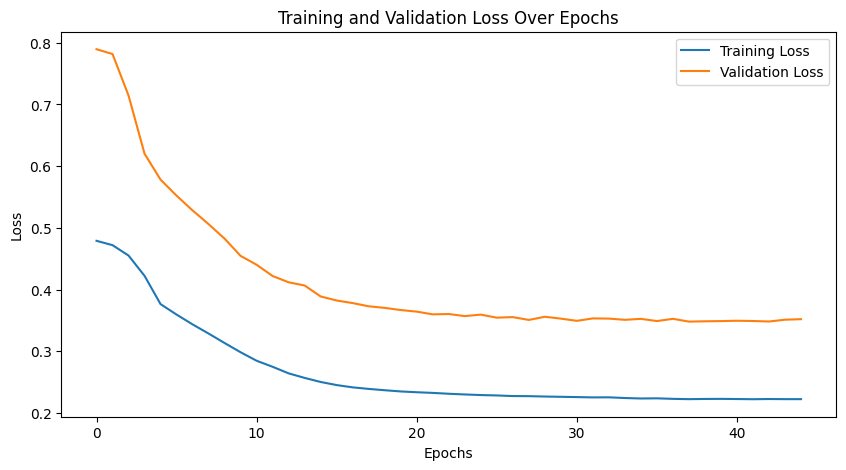

In [27]:
plot_train_val_loss(exp_hist.train_losses, exp_hist.val_losses)

### Plot rec loss as scatterplot

In [ ]:
test_batch_size = 1
benign_test_data_loader, mal_test_data_loader = create_test_ds_loaders(
    benign_data, 
    malicious_data, 
    120, 
    30, 
    features = ['ul_bitrate'], 
    batch_size = test_batch_size
)

In [ ]:
rae_model = LSTMAutoencoder(
    input_dim = len(exp_parameters['feature_columns']), 
    hidden_dim1 = exp_parameters['parameters']['hidden_dim1'], 
    hidden_dim2 = exp_parameters['parameters']['hidden_dim2'], 
    output_dim = len(exp_parameters['feature_columns']), 
    dropout = exp_parameters['parameters']['dropout'], 
    layer_norm_flag = exp_parameters['parameters']['layer_norm_flag']
)

rae_model.load_state_dict(exp_hist.model_weights)
rae_model.to(device)

criterion = nn.L1Loss() if exp_parameters['parameters']['loss_function'] == 'L1Loss' else nn.MSELoss()

In [ ]:
benign_test_losses, mal_test_losses = evaluate(rae_model, criterion, benign_test_data_loader, mal_test_data_loader, device)

In [ ]:
plot_scatter_plot_rec_loss(benign_test_losses, mal_test_losses)

### Plot Roc Curve

In [ ]:
fpr, tpr, thresholds, roc_auc, optimal_threshold = calculate_threshold(benign_test_losses, mal_test_losses)

In [ ]:
plot_roc_curve(fpr, tpr, thresholds , roc_auc)

### Threshold selection & Inference

In [ ]:
optimal_threshold

In [ ]:
accuracy, precision, recall, f1, tp_rate, tn_rate, fp_rate, fn_rate = infer(benign_test_losses, mal_test_losses, optimal_threshold)

### Reconstructed Time Series Visualization

In [ ]:
ue_benign_df = benign_data[
    benign_data['imeisv'] == 8628490433231157
].copy()

ue_malicious_df = malicious_data[
    malicious_data['imeisv'] == 8628490433231157
].copy()

In [ ]:
ue_benign_data_loader, ue_mal_data_loader = create_test_ds_loaders(
    ue_benign_df, 
    ue_malicious_df, 
    120, 
    120, 
    features = ['ul_bitrate'], 
    batch_size = 1
)

In [ ]:
ue_benign_rec = torch.cat([*map(lambda x: rae_model(x[0].to(device)).view(-1), ue_benign_data_loader)]).to('cpu').detach().numpy()
ue_benign = torch.cat([batch.view(-1) for batch, _ in ue_benign_data_loader]).to('cpu').detach().numpy()

ue_mal_rec = torch.cat([*map(lambda x: rae_model(x[0].to(device)).view(-1), ue_mal_data_loader)]).to('cpu').detach().numpy()
ue_mal = torch.cat([batch.view(-1) for batch, _ in ue_mal_data_loader]).to('cpu').detach().numpy()

In [ ]:
plot_ts(ue_benign, ue_benign_rec, 'True Benign', 'Benign rec', range = [-5, 5])

In [ ]:
plot_ts(ue_mal, ue_mal_rec, 'True Malicious', 'Malicious rec', range = [None, None])